In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy  as np
import pandas as pd
import h5py

from tqdm import tqdm
from astropy import units
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from scipy.signal      import argrelextrema

import ehtplot
from matplotlib import pyplot as plt, cm

from common import dalt
from common import hallmark as hm
from common import viz
from common import io_ipole as io
from common import mockservation as ms

In [2]:
from copy import copy
from math import ceil

def truncation_scale(tolerant=0.01, n=2):
    return (1/(tolerant*tolerant) - 1)**(0.5/n)

def compress(imgs, N=None, eht_f=15e9):
    meta = copy(imgs.meta)
    fov  = imgs.fov.to(units.rad).value
    
    spec, U, V = ms.upfft(imgs, *fov, N=N)
    
    u = np.linspace(-U/2,U/2,spec.shape[-2],endpoint=False)
    v = np.linspace( 0,  V/2,spec.shape[-1])
    u, v = np.meshgrid(u, v, indexing='ij')
    
    n  = 2
    rr = (u*u + v*v) / (eht_f*eht_f)
    Bw = 1 / np.sqrt(1 + rr**n)
    
    Nu =    spec.shape[-2]
    Nv = 2*(spec.shape[-1]-1)
    
    scale = truncation_scale(n=n)
    Ndown = [
        2 * ceil(abs(Nu * scale * eht_f / U / 2)),
        2 * ceil(abs(Nv * scale * eht_f / V / 2)),
    ]
    
    print(Bw.shape, spec.shape)
    
    print(Ndown)
    
    I, W, H = ms.downifft(spec * Bw[np.newaxis,:,:], U, V, N=Ndown)
    
    meta.width  = abs(W * meta.dist).to(meta.rg)
    meta.height = abs(H * meta.dist).to(meta.rg)
    return dalt.Image(I, meta=meta)

In [3]:
cmap = cm.get_cmap('afmhot_10us')

def readimg(f):
    with h5py.File(f) as h:
        m    = h['meta']
        meta = dalt.ImageMeta(**{k:m[k][()] for k in m.keys()})
        data = h['data'][:]
        
    return dalt.Image(data, meta=meta)

def mkplot(axes, fmt_mov, eht_f=1e10):
    
    pf_mov  = hm.ParaFrame(fmt_mov)
    #pf_summ = hm.ParaFrame(fmt_summ)
    #print(pf_mov)
    #print(pf_summ)
    
    mov_86GHz  = io.load_mov(pf_mov(freq='86GHz' ).path)
    mov_230GHz = io.load_mov(pf_mov(freq='230GHz').path)
    mov_230GHz_eht = compress(mov_230GHz, eht_f=9e9)
    
    #df_86GHz   = pd.read_csv(pf_summ(freq='86GHz' ).path.iloc[0], sep='\t')
    #df_230GHz  = pd.read_csv(pf_summ(freq='230GHz').path.iloc[0], sep='\t')
    
    viz.show(mov_86GHz,  s=-1, ax=axes[0], cmap=cmap, vmin=0, vmax=np.max(mov_86GHz.value))
    axes[0].set_xlim( 99.9,-99.9)
    axes[0].set_ylim(-99.9, 99.9)
    axes[0].set_xlabel(None)
    axes[0].set_ylabel(None)
    axes[0].set_xticks(range(75,-99,-25))
    axes[0].tick_params(
        axis='both',
        direction='in',
        top=True,
        right=True,
        color='w',
    )
    for spine in axes[0].spines.values():
        spine.set_edgecolor('w')
    
    viz.show(mov_230GHz, s=-1, ax=axes[1], cmap=cmap, vmin=0, vmax=np.max(mov_230GHz_eht.value))
    axes[1].set_xlim( 99.9,-99.9)
    axes[1].set_ylim(-99.9, 99.9)
    axes[1].set_xlabel(None)
    axes[1].set_ylabel(None)
    axes[1].set_xticks(range(75,-99,-25))
    axes[1].tick_params(
        axis='both',
        direction='in',
        top=True,
        right=True,
        color='w',
    )
    for spine in axes[1].spines.values():
        spine.set_edgecolor('w')

    viz.show(mov_230GHz_eht, s=-1, ax=axes[2], cmap=cmap, vmin=0, vmax=np.max(mov_230GHz_eht.value))
    axes[2].set_xlim( 99.9,-99.9)
    axes[2].set_ylim(-99.9, 99.9)
    axes[2].set_xlabel(None)
    axes[2].set_ylabel(None)
    axes[2].set_xticks(range(75,-99,-25))
    axes[2].tick_params(
        axis='both',
        direction='in',
        top=True,
        right=True,
        color='w',
    )
    for spine in axes[2].spines.values():
        spine.set_edgecolor('w')

In [4]:
from astropy.io import fits
from astropy import units as u
from common import dalt as d

with fits.open('model/Frankfurt_thermal/86GHz/SANE/a0.94_i030_R040/SgrA_SANE_a0.94_i029_Rh040_Rl01_sigc01_snorm2.4_t30000_f086GHz.fits') as hdul:
    img = hdul[0].data
img86 = d.Image(img.T, 4.14e6 * u.Msun, 2.5077305106e+22 * u.cm, 86e9 * u.H, 0,
                800 * u.uas.to(u.rad) * 2.5077305106e+22 * u.cm,
                800 * u.uas.to(u.rad) * 2.5077305106e+22 * u.cm)

with fits.open('model/Frankfurt_thermal/SANE20-30kM/a0.94_i030_R040/SgrA_SANE_a0.94_i029_Rh040_Rl01_sigc01_snorm2.4_t30000_f230GHz.fits') as hdul:
    img = hdul[0].data
img230 = d.Image(img.T, 4.14e6 * u.Msun, 2.5077305106e+22 * u.cm, 86e9 * u.H, 0,
                 200 * u.uas.to(u.rad) * 2.5077305106e+22 * u.cm,
                 200 * u.uas.to(u.rad) * 2.5077305106e+22 * u.cm)

img230_eht = compress(img230, eht_f=9e9)

(400, 400) -> [400 400]
(400, 201) (400, 201)
[88, 88]


(-100.0, 100.0)

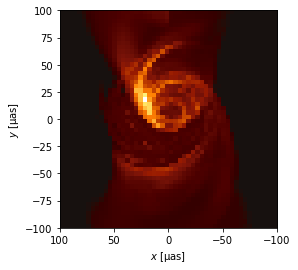

In [5]:
fig, ax = plt.subplots(1,1)
viz.show(img86, ax=ax, cmap='afmhot_10us')
ax.set_xlim( 100,-100)
ax.set_ylim(-100, 100)

(-100.0, 100.0)

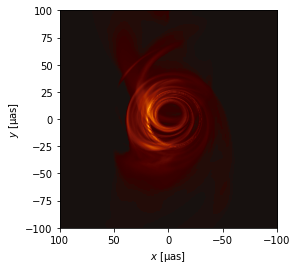

In [6]:
fig, ax = plt.subplots(1,1)
viz.show(img230, ax=ax, cmap='afmhot_10us')
ax.set_xlim( 100,-100)
ax.set_ylim(-100, 100)

(400, 400) -> [400 400]
(400, 201) (1, 400, 201)
[88, 88]
(800, 800) -> [800 800]
(800, 401) (1, 800, 401)
[176, 176]


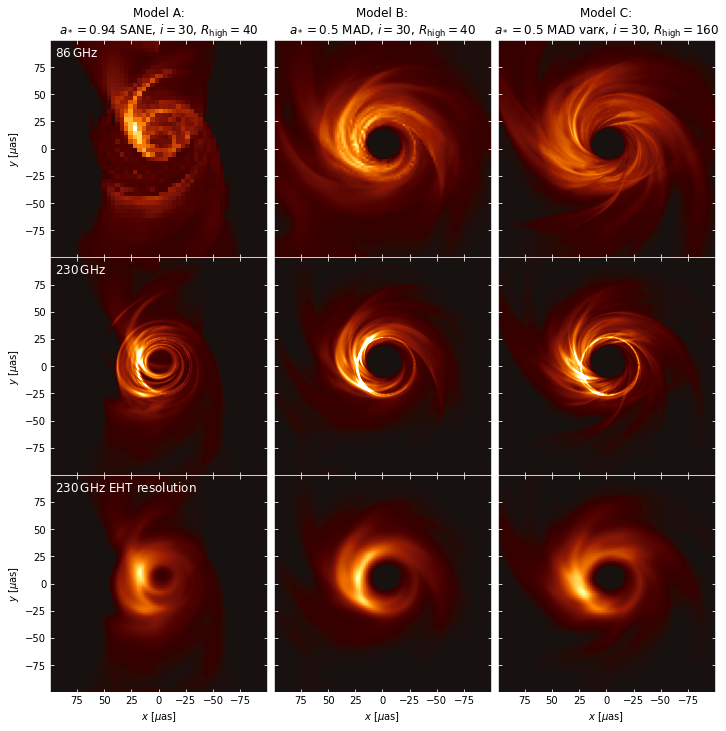

In [11]:
fig, axes = plt.subplots(3,3, figsize=(12,12), sharex=True, sharey=True)
#plt.subplots_adjust(wspace=0, hspace=0)
plt.subplots_adjust(hspace=0, wspace=0.01)

#mkplot(axes[:,0], 'model/Illinois_thermal/{freq}/Sa+0.94_w5/img_s05990_Rh40_i30.h5')
viz.show(img86,           ax=axes[0,0], cmap='afmhot_10us', vmin=0, vmax=np.max(img86.value))
viz.show(img230,          ax=axes[1,0], cmap='afmhot_10us', vmin=0, vmax=np.max(img230_eht.value))
viz.show(img230_eht, s=0, ax=axes[2,0], cmap='afmhot_10us', vmin=0, vmax=np.max(img230_eht.value))
for ax in axes[:,0]:
    ax.tick_params(
        axis='both',
        direction='in',
        top=True,
        right=True,
        color='w',
    )
    for spine in ax.spines.values():
        spine.set_edgecolor('w')

mkplot(axes[:,1], 'model/Illinois_thermal/{freq}/Ma+0.5_w5/img_s05990_Rh40_i30.h5')
mkplot(axes[:,2], 'model/Hamr_varkappa/{freq}/mad_a+0.5/Rhigh_160_Inclination_30/mad_a+5_3487.h5')

axes[0,0].set_title('Model A:\n$a_*=0.94$ SANE, $i=30$, $R_\mathrm{high}=40$')
axes[0,1].set_title('Model B:\n$a_*=0.5$ MAD, $i=30$, $R_\mathrm{high}=40$')
axes[0,2].set_title('Model C:\n$a_*=0.5$ MAD var$\kappa$, $i=30$, $R_\mathrm{high}=160$')
axes[-1,0].set_xlabel('$x$ [$\mu$as]')
axes[-1,1].set_xlabel('$x$ [$\mu$as]')
axes[-1,2].set_xlabel('$x$ [$\mu$as]')
axes[0,0].set_ylabel('$y$ [$\mu$as]')
axes[1,0].set_ylabel('$y$ [$\mu$as]')
axes[2,0].set_ylabel('$y$ [$\mu$as]')
axes[0,0].text(95,85, '$86\,\mathrm{GHz}$',                 color='w', fontsize=12)
axes[1,0].text(95,85, '$230\,\mathrm{GHz}$',                color='w', fontsize=12)
axes[2,0].text(95,85, '$230\,\mathrm{GHz}$ EHT resolution', color='w', fontsize=12)

fig.savefig('output/bestbet_imgs.pdf', bbox_inches='tight')